In [1]:
from simulator.dataset import RandomDataset
from feature.scaler import StandardScaler
from change_graph import ChangeGraph

In [2]:
dataset = RandomDataset(cols=5,
                        changing_cols=4,
                        change_start=0,
                        num_changepoints=5,
                        drift_steps=50,
                        mean_ball=20,
                        size=10000)

dataset.generate(True)
pass

100%|██████████| 10000/10000 [00:00<00:00, 11555.13it/s]


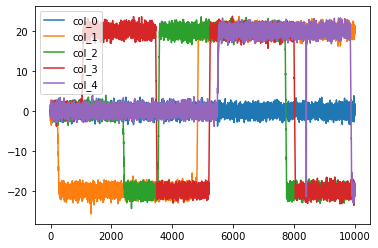

In [74]:
dataset.plot(True)

In [75]:
df = dataset.to_df()
df.head()

,col_0,col_1,col_2,col_3,col_4,target_cols,mean_gradient,change
0,0.016217,0.686242,0.124280,-0.691462,0.171495,None,0.0,0
1,-2.514888,1.463790,1.400174,1.523263,1.839621,None,0.0,0
2,0.722318,-1.563490,-1.265539,-0.724355,1.147211,None,0.0,0
3,0.267222,-0.922050,0.867147,0.422220,-1.353138,None,0.0,0
4,-1.658929,-0.014559,-0.356327,0.390698,-0.119047,None,0.0,0


In [76]:
model = ChangeGraph(num_features=dataset.changing_cols,
                    cat_features=[],
                    window_size=50,
                    num_scaler=StandardScaler,
                    custom_start=0,
                    threshold=.6)
model

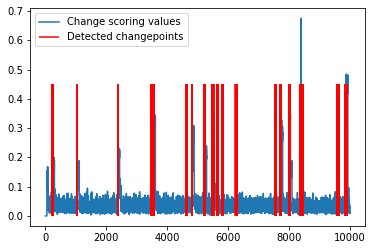

In [79]:
import numpy as np

top_n = [1, 3, 5]
results = []

scores = []
idx = []

for i, x in df.iterrows():
    x = x.to_dict()
    triggered, total_avg, cat, num = model.learn_one(i, x, None)
    num_avg, features, feature_scores = num
    scores.append(num_avg)
    target_cols_str: str = x['target_cols']
    if triggered and not target_cols_str is None:
        idx.append(i)
        target_cols = target_cols_str.split(',')
        num_features = len(target_cols)
        target_cols_set = set(target_cols)
        top_res = []
        for top in top_n:
            top = max(num_features, top)
            pred_cols_set = set(features[:top])
            inter = target_cols_set & pred_cols_set
            score = len(inter) / len(target_cols)
            top_res.append(score)
        results.append(top_res)

res_arr = np.asarray(results)
res_mean = np.mean(res_arr, axis=0)

import pandas as pd

df_res = pd.DataFrame(data=[res_mean], columns=[f'top_{n}' for n in top_n])
df_res.to_csv('res_top.csv', index=False)

import matplotlib.pyplot as plt

plt.plot(scores, label='Change scoring values')
plt.vlines(idx, 0, max(scores)*2/3, color='red', label='Detected changepoints')
# plt.show()
plt.legend()

plt.savefig('drift.png', format='png')

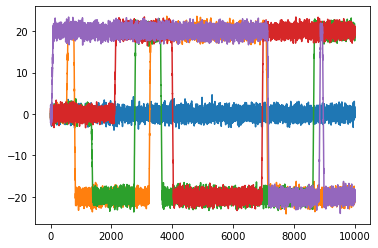

In [40]:
df.to_csv('xpl.csv', index=False)
dataset.plot(False, 'plot.png')

# ------------------

In [1]:
from simulator.dataset import RandomDataset
from feature.scaler import StandardScaler
from change_graph import ChangeGraph
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import json

feature_count = [5, 10, 50, 100, 200]
# feature_count = [5]

# sample_size = [1000, 10000]
sample_size = [10000, 50000]

change_ratio = [0, .05, .1, .3]
# change_ratio = [.5]

top_n = [1, 3, 5]

times = 100

bar = tqdm(total=(len(feature_count)*len(sample_size)*len(change_ratio)*times))

cols = ['sample_size', 'feature_count', 'change_ratio', *[f'top_{n}' for n in top_n]]
all_res = []
all_feature_data = []

all_all_res = []

for _ in range(times):
    for s in sample_size:
        for f in feature_count:
            for r in change_ratio:
                bar.update(1)
                np_changing_cols = int(f*r)
                # print(list(np.random.randint(5, 21, size=np_changing_cols)))
                dataset = RandomDataset(cols=f,
                                changing_cols=int(f*r),
                                change_start=0,
                                num_changepoints=0 if not np_changing_cols else np.random.randint(1, np_changing_cols+1),
                                drift_steps=50,
                                mean_ball=list(np.random.randint(5, 21, size=np_changing_cols)),
                                size=s)
                dataset.generate()
                df = dataset.to_df()
                # df.to_csv(f'xpl_data/data_samples{s}_features{f}_changeratio{r}.csv', index=False)
                # dataset.plot(False, f'xpl_data/plot_samples{s}_features{f}_changeratio{r}.png')
                plt.close()
                # model
                model = ChangeGraph(num_features=dataset.cols if not dataset.changing_cols else dataset.changing_cols,
                        cat_features=[],
                        window_size=30,
                        num_scaler=StandardScaler,
                        custom_start=0,
                        threshold=.6)
                top_n_results = [] # top_n array
                avg_scores = [] # contains change scores (scoring function)
                feature_data = defaultdict(list)
                for i, x in df.iterrows():
                    x = x.to_dict()
                    triggered, total_avg, cat, num = model.learn_one(i, x, None)
                    num_avg, features, feature_scores = num
                    avg_scores.append(num_avg)
                    for j, f_col in enumerate(features):
                        feature_data[f_col].append(feature_scores[j])
                    target_cols_str: str = x['target_cols']
                    if triggered and not target_cols_str is None:
                        target_cols = target_cols_str.split(',')
                        num_features = len(target_cols)
                        target_cols_set = set(target_cols)
                        top_res = []
                        for top in top_n:
                            top = max(num_features, top)
                            pred_cols_set = set(features[:top])
                            inter = target_cols_set & pred_cols_set
                            score = len(inter) / len(target_cols)
                            top_res.append(score)
                        top_n_results.append(top_res)
                        # print(f'top_n_results: {top_n_results}')
                # top_n
                res_arr = np.asarray(top_n_results)
                # features
                feature_scores = np.asarray(list(zip(*feature_data.values())))
                split = np.asarray(np.split(np.asarray(feature_scores), 20))
                maxes = np.max(split, axis=1)
                # sns.heatmap(maxes, xticklabels=feature_data.keys())
                # sns.heatmap(maxes)
                # plt.savefig(f'xpl_data/heatmap_samples{s}_features{f}_changeratio{r}.png')
                # plt.close()
                # save feature scores
                # with open(f'xpl_data/feature_scores_samples{s}_features{f}_changeratio{r}.json', 'w') as file:
                #     json.dump(feature_data, file)
                # scores
                # scores = np.asarray(avg_scores)
                # np.save(f'xpl_data/scores_samples{s}_features{f}_changeratio{r}.npy', scores)
                # plt.plot(scores)
                # plt.savefig(f'xpl_data/scores_samples{s}_features{f}_changeratio{r}.png')
                # plt.close()
                
                try:
                    res_mean = [round(i, 3) for i in np.mean(res_arr, axis=0)]
                    all_res.append([s, f, r, *res_mean])
                except:
                    all_res.append([s, f, r, 0, 0, 0])

    all_all_res.append(all_res)
    # all_res = np.asarray(all_res)
    # print(all_res.shape)
    # print(all_res)

all_all_res = np.asarray(all_all_res)
# print(all_all_res)
# print('---')
all_all_res = np.mean(all_all_res, axis=0)
# print(all_all_res)
# print(all_all_res.shape)

res_df = pd.DataFrame(all_all_res, columns=cols)
res_df.to_csv('big_data_xpl/results.csv', index=False)

# res_df = pd.DataFrame(all_res, columns=cols)
# res_df.to_csv('big_data_xpl/results.csv', index=False)

# dataset = RandomDataset(cols=10,
#                         changing_cols=6,
#                         change_start=0,
#                         num_changepoints=5,
#                         drift_steps=50,
#                         mean_ball=20,
#                         size=100)

# dataset.generate(True)
# dataset.plot(True)

  0%|          | 0/4000 [00:00<?, ?it/s]c:\Users\Dastamn\anaconda3\envs\ml\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\Dastamn\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 28%|██▊       | 1119/4000 [7:17:52<51:50:47, 64.79s/it] 

KeyboardInterrupt: 

In [2]:
'''
In order to acess our ability to target the changing features we propose 
the following evaluation protocol: we run our change detection algorithm 
on multiple synthetic multivariate datasets with different sample sizes and feature counts
we also vary the portion of features that is drifting. For each iteration, our algorithm
ouputs for each feature scores that quatify the amount of drift that is detected.
We then compute top 1, 3 and 5 accuracies. The results are reported in table X.
'''

['col_0', 'col_9']

In [7]:
[list(np.random.randint(5, 21, size=2)) for _ in range(10)]

[[18, 11],
 [9, 7],
 [6, 12],
 [19, 19],
 [13, 16],
 [20, 9],
 [16, 19],
 [6, 7],
 [5, 11],
 [7, 8]]